<h1 align="center">Fold modelling - Axial surface optimisation tutorial Part I</h1>


#### Overview

This tutorial demonstrates the use of a newly developed computational method for approximating fold axial surfaces. This section integrates algorithms proposed by Laurent et al. (2016) [Laurent et al. (2016)](https://linkinghub.elsevier.com/retrieve/pii/S0012821X16305209) with a data-driven approach from [Grose et al. (2017)](https://gmd.copernicus.org/articles/14/3915/2021/) and the geological likelihood functions of [Grose et al. (2019)](https://linkinghub.elsevier.com/retrieve/pii/S0191814118303638) to address the challenge of estimating planar fold axial surfaces in poorly outcropping regions.

#### Solving the Axial Surface Optimization Problem

The axial surface optimisation problem is addressed through a multi-step computational algorithm that involves:

1. **Maximum Likelihood Estimation (MLE)**: The method uses MLE to estimate model parameters that define the axial surface: strike and dip or a 3D unit vector. MLE finds the most probable parameters (like the 3D unit vector representing the axial surface) by maximising a likelihood function based on the observed data and/or geological knowledge.

2. **Incorporating Geological Knowledge**: A key aspect of this approach is the inclusion of geological knowledge constraints, such as fold tightness, asymmetry, and axial traces. These constraints are used to guide the optimisation process, ensuring that the resulting model aligns with observations and Structural Geological concepts.

3. **Optimisation Techniques**: The method leverages optimisation techniques like the Differential Evolution algorithm, which helps in navigating complex parameter spaces and ensures a robust search for the optimal axial surface.

4. **Objective Function the relationship between the folded foliation and axial surface**: An objective function is used to evaluate the geometrical relationship between the axial surface and the folded surface, ensuring the geometrical compatibility between the folded foliation and its axial surface.

5. **Final Solution**: The result of this method is a data-driven and geologically informed model of the axial surface.

##### Pre-requisites: 
- **[LoopStructural-Fold Frame tutorial](https://github.com/Loop3D/LoopStructural/blob/master/examples/2_fold/plot_adding_folds_to_surfaces.py)**
- **[Fourier series optimisation tutorial](https://github.com/Loop3D/FoldOptLib/blob/main/FoldOptLib/examples/fourier_series_optimisation.ipynb)**


In [1]:
from misc_functions import sample_random_dataset
from FoldOptLib.FoldOptLib.optimisers import AxialSurfaceOptimiser as ASO
from FoldOptLib.FoldOptLib.optimisers import FourierSeriesOptimiser as FSO
from FoldOptLib.FoldOptLib.helper.utils import create_fold_frame_dataset, create_dataset, clean_knowledge_dict
from LoopStructural import GeologicalModel
from LoopStructural.modelling.features.fold import FoldEvent
# from LoopStructural.visualisation import LavaVuModelViewer
# from custom_model_visualisation import LavaVuModelViewer
from LoopStructural.visualisation import MapView
from LoopStructural.visualisation import RotationAnglePlotter
from LoopStructural.modelling.features.fold import FoldRotationAngle, SVariogram
from LoopStructural.modelling.features import StructuralFrame, GeologicalFeature
from LoopStructural.modelling.features.fold import fourier_series
from LoopStructural.utils.helper import create_surface, create_box, get_data_bounding_box, normal_vector_to_strike_and_dip, plunge_and_plunge_dir_to_vector
import os
import time
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import IntProgress, interact, interactive

ERROR: 2023-10-26 11:08:50,046: __init__.py:21 -- Cannot use sphinx scraper, pip install -r docs/requirements.txt
ERROR: 2023-10-26 11:08:50,050: __init__.py:25 -- Missing lavavu, can't import LavaVuModelViewer


# I. Creation of a synthetic model  

Like the Fourier series tutorial, we will start by creating a synthetic model. The synthetic model is the reference from within which we will sample data points that will be used to infer the axial surface.  

1. Define model bounding box

In [2]:
# define the maximum value of xyz model box boundaries
xmin, ymin, zmin = 0, 0, 0
xmax, ymax, zmax = 1000, 1000, 1000

bounding_box = np.array([[xmin, ymin, zmin],
               [xmax, ymax, zmax]])

2. Initialise a geological model 

In [3]:
# initiliase geological model by initialising GeologicalModel class
model = GeologicalModel(bounding_box[0, :], 
                        bounding_box[1, :])

3. Build a fold frame

In [4]:
# Create a dataset for s1 to build a fold frame 
dataset, xyz = create_fold_frame_dataset(model, strike=0, dip=90)
# add data to the initiliased geological model
model.data = dataset

In [5]:
# build the s1 fold frame
s1 = model.create_and_add_fold_frame('s1',
                                          buffer=0.3,
                                          solver='cg',
                                          nelements=2e4,
                                        damp=True)
model.update()

  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:09:23,161: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


In [6]:
# # 3D displaying the s1 fold frame
# # import lavavu
# viewer = LavaVuModelViewer(model, background='white')
# viewer.add_isosurface(s1[0], colour='red')
# viewer.add_isosurface(s1[1], colour='blue')
# viewer.add_data(s1[0], disks=False, vectors=True, colour='red')
# viewer.add_data(s1[1], disks=False, vectors=True, colour='blue')
# # t = viewer.add_scalar_field(s1[0], cmap='prism')
# # viewer.lv.colourbar(t, align=("bottom"))
# viewer.lv.rotate([-63.015506744384766, -24.475210189819336, -8.501092910766602])
# viewer.display()
# viewer.interactive()

4. Define the fold limb rotation angle profile

In [7]:
def fold_limb_rotation_profile(c0, c1, c2, wl):

    theta = [c0, c1, c2, wl]
    x = np.linspace(s1[0].min(), s1[0].max(), 100)
    flr = np.rad2deg(np.arctan(fourier_series(x, *theta)))
    fold_limb_rotation = FoldRotationAngle(flr, x) 
    fold_limb_rotation.fitted_params = theta
    fold_limb_rotation.set_function(lambda x: np.rad2deg(
                    np.arctan(fourier_series(x, *theta))))
    plt.ylim(-90, 90)
    plt.xlabel('Fold Axial Surface Field')
    plt.ylabel('Fold Limb Rotation Angle')
    plt.title('Fold Limb S-Plot')
    plt.plot(x, flr)
    plt.show()
    
    return fold_limb_rotation

def define_fold_axis_orientation(plunge_direction, plunge): 
    
    fold_axis = plunge_and_plunge_dir_to_vector(plunge, plunge_direction)
    
    return fold_axis

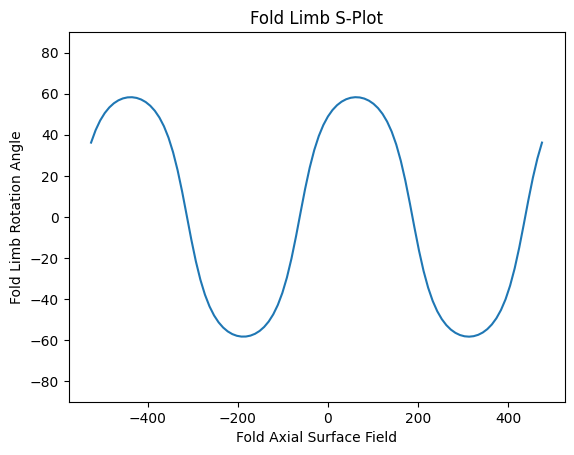

In [8]:
theta = [0, 2e-2, 2e-2, 500]
fold_limb_rotation = fold_limb_rotation_profile(*theta)

**5. Calculate the normal vectors to the folded foliation**

The next lines of code define the orientation of the folded foliation within the fold frame. 
Let's break down the steps to understand the computations involved in this code snippet.

###### **- Defining Fold Axis Orientation**
Initially, the code defines a fold axis orientation based on a given plunge direction and plunge angle. The `define_fold_axis_orientation` function is used for this purpose, which returns the fold axis orientation vector.

###### **- Creating a Fold Event**
A `FoldEvent` object is created, representing a geological fold event. This object is initialised with the fold frame `s1` and the `fold_limb_rotation`. Later, the fold axis orientation vector `fold_axis` is assigned to this `FoldEvent` object.

###### **- Computing Deformed Orientation**
The `get_deformed_orientation` method is invoked on the `FoldEvent` object to compute the deformed orientation of the folded foliation. This method returns three values: the fold direction vectors, the fold axis vector, and the gradient of the scalar field of the X-axis of the fold frame.

###### **- Normalizing Vectors**
The gradient of S1, `dgx` and the fold direction vectors are normalized to ensure they have unit lengths.

###### **- Correct fold direction vectors with S1**
The dot product between `dgx` and the fold direction vectors is calculated to align any inverted fold direction vectors with the axial surface's direction to ensure consistency. If the dot product is negative, the fold direction vectors are inverted.

###### **- Computing Normal Vectors**
The normal vectors of the folded foliation are computed using the cross-product of the fold axis and the fold direction vectors. The cross-product yields a vector that is perpendicular to the plane defined by the fold axis and fold direction vectors.

In [9]:
plunge_direction = 0
plunge = 0
fold_axis = define_fold_axis_orientation(plunge_direction, plunge)
fold = FoldEvent(s1, fold_limb_rotation=fold_limb_rotation)
fold.fold_axis = fold_axis 
fold_direction, fold_axis, dgz = fold.get_deformed_orientation(xyz)
dgx = s1[0].evaluate_gradient(xyz)
dgx /= np.linalg.norm(dgx, axis=1)[:, None]
# make sure fold direction vectors are normalised
fold_direction /= np.linalg.norm(fold_direction, axis=1)[:, None]
# calculate the dot product of the s1 and the fold direction
dot = np.einsum('ij,ij->i', dgx, fold_direction)
# correct the orientation of the fold direction vectors to be consistent
# with the direction of the axial surface 
fold_direction[dot<0] *= -1
# calculate the normal vectors of the folded foliation 
# which are the cross product of the fold axis and 
# the fold direction vectors
s0n = np.cross(fold_axis, fold_direction)
# normalise s0 normal vectors
s0n /= np.linalg.norm(s0n, axis=1)[:, None]

6. Create a dataset for s0

In [10]:
dataset = pd.DataFrame()
dataset['X'] = xyz[:, 0]
dataset['Y'] = xyz[:, 1]
dataset['Z'] = xyz[:, 2]
dataset['gx'] = s0n[:, 0]
dataset['gy'] = s0n[:, 1]
dataset['gz'] = s0n[:, 2]
dataset['feature_name'] = 's0'
dataset['coord'] = 0

7. Build a 3D model of s0

In [11]:
fold_function = fold_limb_rotation.fold_rotation_function
model.data = dataset.sample(frac=0.2)
s0 = model.create_and_add_folded_foliation('s0',
                                           fold_frame=s1,
                                            # limb_wl=500,
                                            av_fold_axis=True,
                                            limb_function=fold_function,
                                            nelements=1e5,
                                            solver='cg',
                                            buffer=0.3,
                                            damp=True)
model.update()
# s0.fold.fold_limb_rotation.fitted_params = theta

  0%|          | 0/4 [00:00<?, ?it/s]

- Check the fold limb rotation angle if it is correct

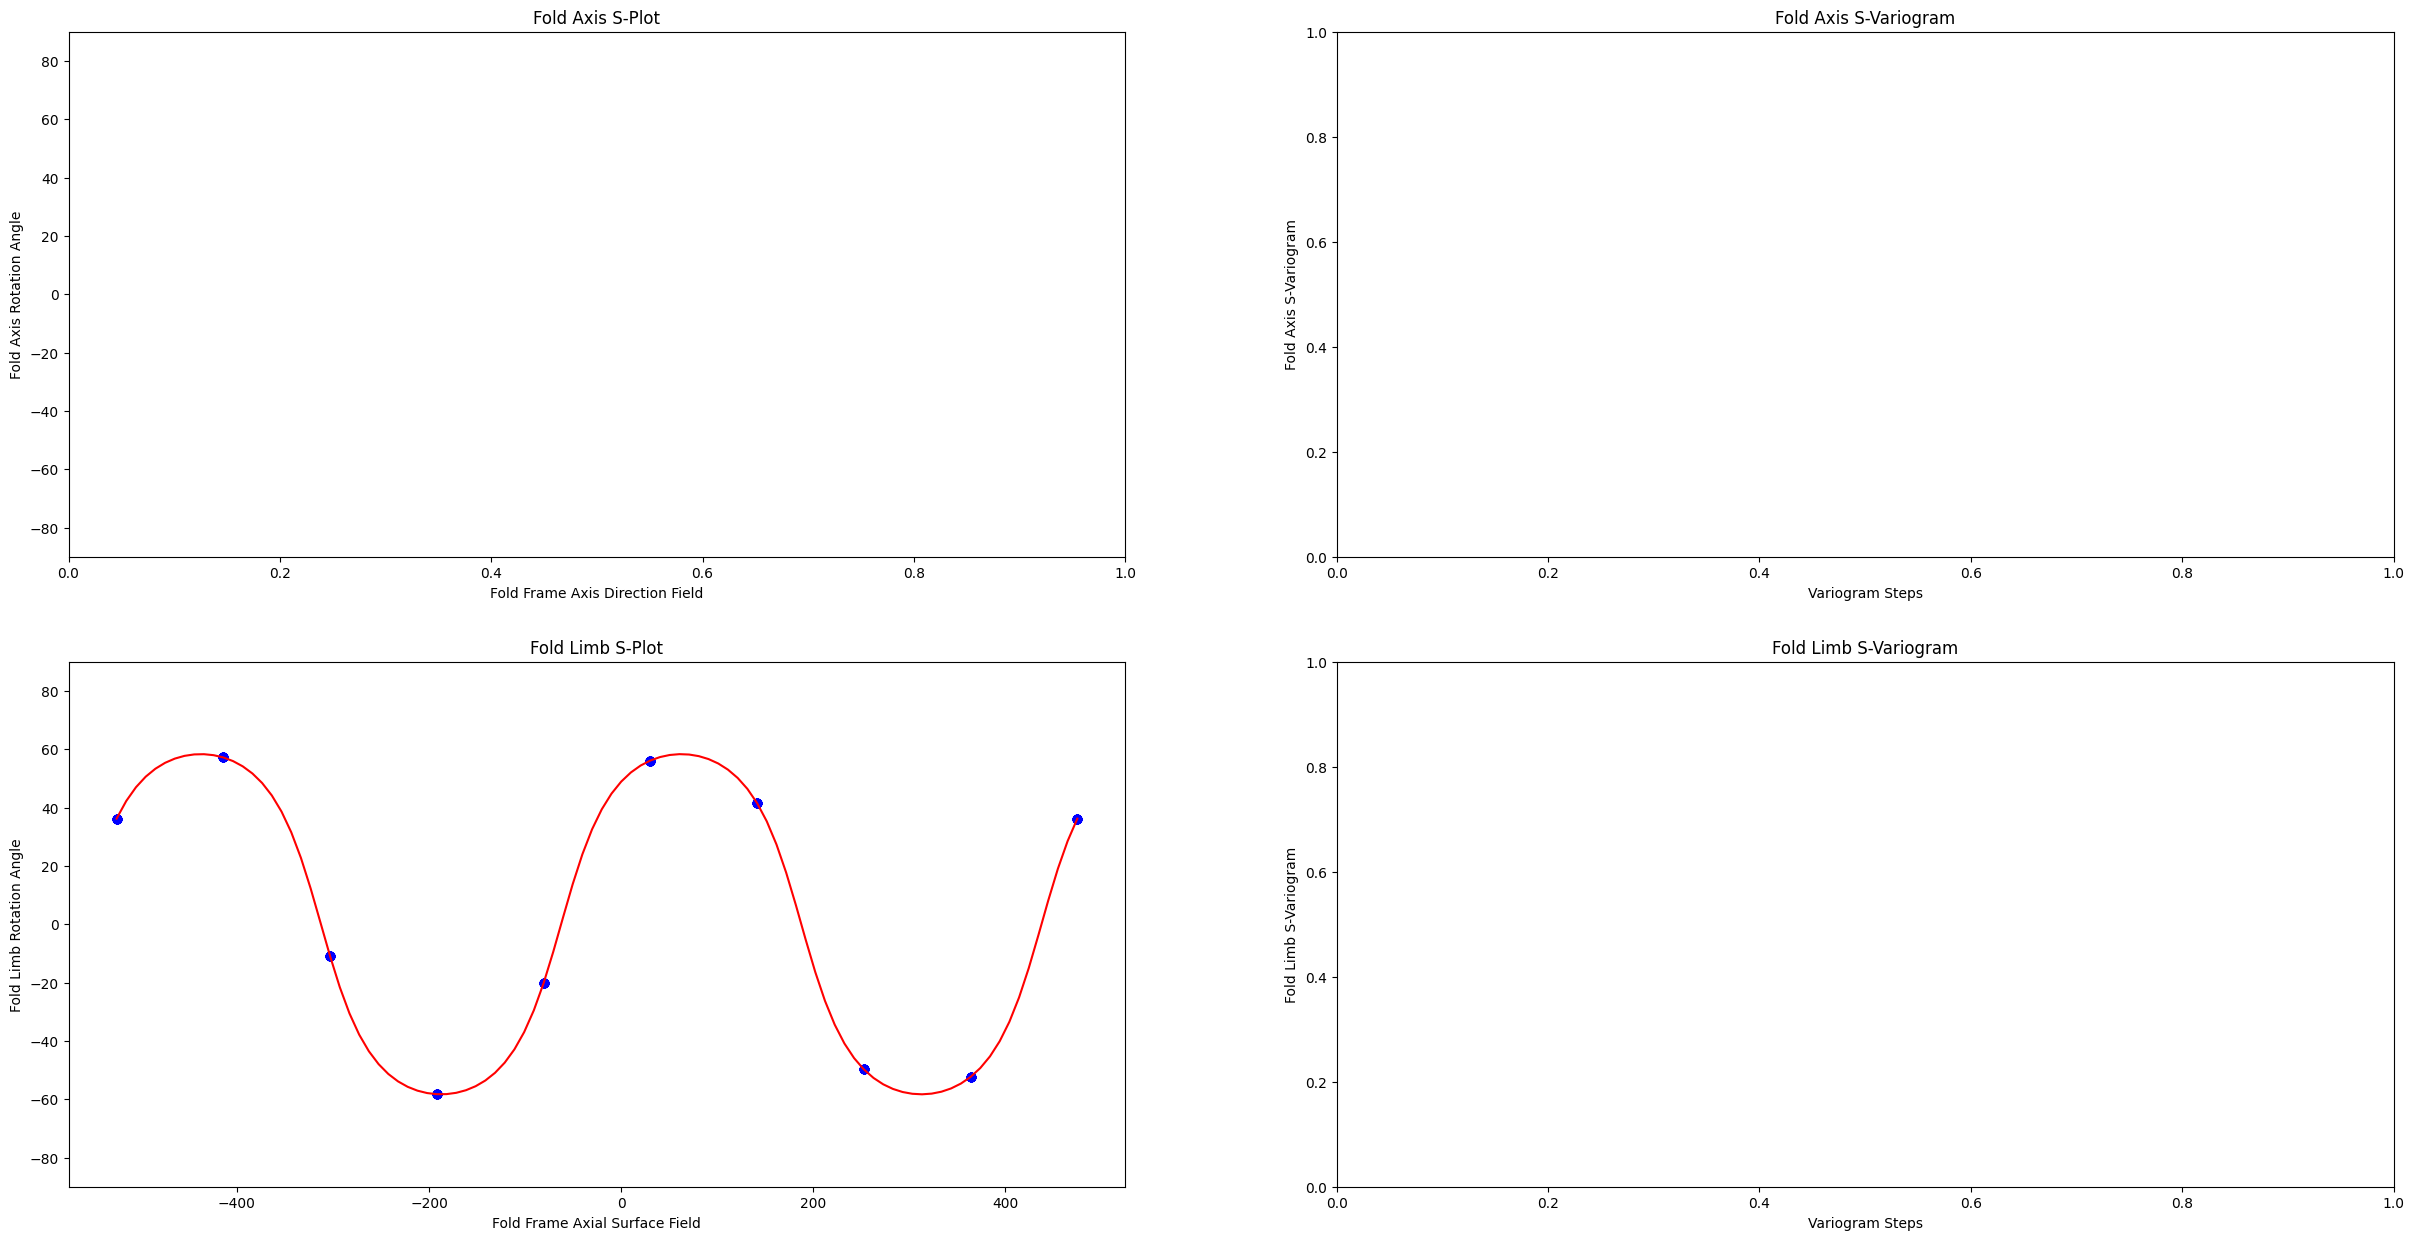

In [12]:
s0.set_model(model)
plotter = RotationAnglePlotter(s0)
plotter.default_titles()
plotter.add_fold_limb_data()
plotter.add_fold_limb_curve()
# plotter.add_limb_svariogram()
plt.show()

- Visualise the 3D model of s0

In [13]:
# viewer = LavaVuModelViewer(model, background='white')
# viewer.nsteps = np.array([100, 100, 100])
# t = viewer.add_scalar_field(s0, cmap='prism')
# # viewer.lv.colourbar(t, align=("bottom"))
# viewer.lv.rotate([-63.015506744384766, -24.475210189819336, -8.501092910766602])
# viewer.display()
# viewer.interactive()

# II. Axial surface optimisation

- **write a brief intro of what will happen in this section**

###### **1. Sampling S<sub>0</sub> from the reference model**  

Now, we sample a random dataset from the reference model we just built. 


In [41]:

def update(sample_size):
    global points, s0g
    points = sample_random_dataset(xyz, sample_size=sample_size, seed=180)
    # Evaluate the gradient of the folded foliation using points 
    s0g = s0.evaluate_gradient(points) 
    # normalise the gradient 
    s0g /= np.linalg.norm(s0g, axis=1)[:, None] 
    
# Create a slider for sample_size
sample_size_slider = widgets.IntSlider(
    value=4,
    min=1,
    max=100,
    step=1,
    description='Sample Size:',
    continuous_update=True
)

# Use interact to create the interactive widget
interactive_sampling = interactive(update, sample_size=sample_size_slider)


display(interactive_sampling)


interactive(children=(IntSlider(value=4, description='Sample Size:', min=1), Output()), _dom_classes=('widget-…

Now, we create a dataset called `test_data` using the random sample. The dataset should be a *Pandas Dataframe*.

In [45]:
# Create a dataframe
test_data = pd.DataFrame()
test_data['X'] = points[:, 0]
test_data['Y'] = points[:, 1]
test_data['Z'] = points[:, 2]
test_data['gx'] = s0g[:, 0]
test_data['gy'] = s0g[:, 1]
test_data['gz'] = s0g[:, 2]
test_data['feature_name'] = 's0'
test_data['coord'] = 0

At this stage, we will use the dataset we built in the previous cell to find the orientation of the axial that is compatible with the folded foliation `s0`. To find the axial surface, we use the `AxialSurfaceOptimiser` class that contains the functions necessary to run an axial surface optimisation. The axial surface optimisation algorithm proceeds as follows:  
1. Define geological knowledge constraints if available
2. Build the fold frame
3. Calculate the fold rotation angles
4. Fit Fourier series parameters to the fold rotation angles 
5. Calculate the orientation of the predicted bedding 
6. Calculate the angle between the observed and the predicted bedding 
7. Optimise the normal log-likelihood function that finds the optimal axial surface

The `AxialSurfaceOptimiser` class is designed to optimise the axial surfaces based on the provided data, bounding box, and geological knowledge. To initialise the `AxialSurfaceOptimiser` we use the following parameters: 


---
-`data`: the input data for optimisation which should be a pd.DataFrame  
-`bounding_box`: The bounding box for the optimisation. Which should be a list or a NumPy array.   
-`geological_knowledge`: The geological knowledge used for optimisation, by default None. If used, the input should be a nested python dictionary. See [Fourier series optimisation tutorial](https://github.com/Loop3D/FoldOptLib/blob/main/FoldOptLib/examples/fourier_series_optimisation.ipynb) for the structure of the dictionary.   
-`**kwargs`: Other optional parameters for optimisation.  
* `axial_surface_guess`: an estimate of the axial surface to provide to the algorithm to speed up optimisation. It should be a list in the following format: [strike, dip]  
* `av_fold_axis`: True for cylindrical folds and False for noncylindrical folds. 
It can include SciPy optimisation parameters for differential evolution and trust-constr methods.  
    `mode`: the optimisation mode to use, can be 'restricted' or 'unrestricted', by default 'unrestricted'. only unrestricted mode is supported for now.  
    `method`: the optimisation algorithm to use, can be 'differential_evolution' or 'trust-region',
    by default 'differential_evolution'.  


In the following example, we will use only data (test_data) to find the optimal axial surface. 

In [51]:
aso = ASO(test_data, 
          bounding_box, 
          method='differential_evolution', 
          axial_surface_guess=[90, 50], 
          av_fold_axis=True
         )

In [49]:
results = aso.optimise()

  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:02:58,066: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:02:59,692: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:01,782: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:03,842: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:05,700: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:08,029: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:10,215: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:12,675: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:14,775: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:16,852: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:20,946: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:23,149: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:25,435: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:28,346: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:31,381: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:33,598: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:47,391: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:49,708: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:52,336: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:55,123: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:03:58,703: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:04:07,299: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:04:17,303: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:04:21,265: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:04:23,930: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:04:33,449: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:04:37,729: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:04:41,703: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:04:47,806: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:04:49,765: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:04:53,542: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:04:57,817: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:01,430: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:03,849: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:06,104: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:12,660: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:14,637: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:18,346: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:20,863: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:26,528: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:28,989: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:31,673: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:34,177: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:48,648: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:50,568: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:52,699: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:55,895: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:05:59,008: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:00,901: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:12,355: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:15,273: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:18,637: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:20,916: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:22,851: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:24,988: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:26,908: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:28,983: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:32,940: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:36,957: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:39,746: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:41,727: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:43,929: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:45,903: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:47,606: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:06:59,508: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:01,666: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:05,326: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:09,871: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:12,059: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:21,367: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:23,372: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:25,440: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:27,571: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:31,139: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:38,085: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:41,275: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:47,753: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:49,836: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:52,527: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:55,676: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:07:57,916: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:00,226: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:02,538: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:04,940: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:06,979: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:09,491: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:12,245: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:14,482: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:16,352: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:19,328: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:21,691: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:23,807: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:26,505: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:34,331: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:36,379: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:38,250: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:40,255: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:42,332: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:44,436: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:46,488: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:49,014: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:52,161: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:08:57,724: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:00,869: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:03,265: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:07,321: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:09,227: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:11,356: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:14,038: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:17,575: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:21,431: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:23,523: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:25,697: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:28,305: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:30,463: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:32,605: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:34,852: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:37,251: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:39,044: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:41,040: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:45,346: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:47,222: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:49,253: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:51,351: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:55,953: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:58,074: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:09:59,899: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:01,774: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:03,602: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:06,166: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:08,690: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:13,721: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:15,810: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:17,871: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:20,512: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:22,712: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:26,252: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:28,217: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:30,524: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:33,109: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:42,657: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:44,836: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:46,983: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:49,426: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:52,073: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:54,279: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:56,941: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:10:59,232: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:01,811: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:03,658: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:06,181: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:08,451: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:10,614: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:13,060: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:15,393: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:17,351: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:22,011: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:24,105: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:26,209: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:28,625: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:30,621: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:32,596: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:34,775: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:38,402: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:40,947: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:42,800: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:46,262: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:48,315: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:51,750: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:53,785: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:55,588: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:57,310: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:11:59,291: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:02,137: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:05,100: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:08,105: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:10,700: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:12,910: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:14,841: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:17,238: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:19,741: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:22,627: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:24,615: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:26,575: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:31,067: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:32,838: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:35,063: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:37,209: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:40,339: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:42,148: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:48,448: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:50,754: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:53,377: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:55,175: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:57,377: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:12:59,147: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:01,333: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:03,726: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:06,021: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:08,211: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:10,276: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:13,528: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:15,815: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:18,009: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:20,428: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:22,426: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:26,724: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:28,705: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:32,982: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:36,608: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:38,527: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:40,892: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:45,811: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:48,107: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:50,125: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:54,206: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:56,223: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:13:58,181: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:00,045: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:01,837: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:05,357: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:07,575: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:09,563: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:12,227: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:14,318: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:16,326: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:18,455: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:20,582: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:22,554: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:25,312: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:27,615: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:29,769: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:31,821: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:35,200: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:37,232: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:39,428: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:42,542: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:44,733: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:47,038: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:49,329: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:51,491: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:54,081: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:55,869: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:14:57,897: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:00,438: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:02,627: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:04,776: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:06,631: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:08,127: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:10,447: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:14,201: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:16,083: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:17,773: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:22,150: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:25,673: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:27,986: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:30,252: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:32,671: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:36,791: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:39,027: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:41,674: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:43,831: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:45,900: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:47,835: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:49,940: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:51,996: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:53,981: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:57,004: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:15:58,919: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:01,060: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:02,997: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:06,114: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:08,869: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:10,647: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:13,659: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:16,018: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:18,050: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:19,909: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:22,681: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:24,962: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:27,371: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:30,203: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:32,593: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:36,068: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:38,222: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:40,934: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:43,926: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:47,696: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:49,495: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:52,684: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:54,902: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:16:58,829: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:01,351: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:03,606: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:05,594: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:07,862: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:10,163: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:12,116: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:15,141: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:17,145: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:19,022: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:20,991: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:22,991: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:25,031: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:28,326: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:30,085: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:31,760: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:35,234: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:37,302: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:39,258: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:40,968: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:42,725: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:45,027: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:49,357: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:51,135: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:52,880: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:55,003: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:17:59,008: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:00,919: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:05,238: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:06,866: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:08,678: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:11,004: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:13,065: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:14,674: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:19,835: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:21,994: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:25,387: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:28,581: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:30,975: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:33,814: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:36,542: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:40,743: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:43,219: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:45,688: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:47,611: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:49,885: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:51,918: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:18:57,752: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:00,130: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:02,245: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:04,511: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:06,346: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:08,430: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:10,562: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:12,810: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:15,163: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:18,795: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:20,887: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:22,740: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:35,971: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:38,034: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:40,494: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:44,468: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:47,384: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:51,593: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:55,070: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:56,797: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:19:58,711: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:00,990: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:02,765: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:04,733: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:06,429: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:12,045: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:14,575: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:16,576: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:18,536: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:20,497: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:22,408: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:24,578: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:26,337: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:28,180: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:30,353: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:32,533: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:34,410: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:36,597: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:38,778: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:41,087: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:43,083: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:45,113: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:47,421: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:49,425: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:54,441: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:56,342: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:20:58,577: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:00,888: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:03,196: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:05,311: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:07,701: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:09,898: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:12,294: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:15,310: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:18,142: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:20,184: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:22,842: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:25,919: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:28,108: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:31,461: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:34,192: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:36,737: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:38,855: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:41,113: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:43,886: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:46,509: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:48,895: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:50,874: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:53,369: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:55,797: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:21:58,124: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:02,233: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:04,679: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:06,823: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:09,326: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:11,974: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:15,092: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:17,295: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:19,969: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:21,975: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:24,150: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:26,615: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:28,692: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:30,935: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:33,630: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:35,877: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:37,677: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:39,517: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:43,959: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:46,164: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:48,097: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:50,081: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:52,026: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:53,895: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:55,650: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:57,579: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:22:59,418: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:01,409: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:03,093: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:05,109: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:06,846: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:08,583: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:10,389: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:12,208: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:15,867: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:18,086: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:20,509: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:22,831: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:25,059: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:27,185: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:29,637: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:31,809: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:33,968: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:36,822: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:38,736: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:40,504: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:42,247: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:44,252: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:46,172: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:47,876: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:50,877: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:53,054: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:55,009: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:56,990: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:23:59,082: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:00,980: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:02,826: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:05,980: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:08,039: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:09,829: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:11,979: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:13,809: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:15,901: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:18,035: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:20,238: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:22,659: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:25,152: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:27,472: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:29,567: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:31,860: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:33,787: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:35,659: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:38,013: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:40,457: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:42,463: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:46,212: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:48,078: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:49,819: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:51,346: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:53,227: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:55,266: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:56,986: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:24:58,743: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:00,342: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:02,165: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:03,873: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:06,936: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:08,828: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:10,747: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:13,714: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:17,102: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:19,487: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:21,514: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:23,678: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:25,963: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:30,084: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:32,124: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:34,141: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:37,977: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:40,383: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:42,723: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:44,836: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:46,946: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:49,345: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:51,265: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:53,228: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:55,260: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:57,411: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:25:59,602: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:01,790: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:03,762: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:05,561: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:07,271: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:09,126: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:10,926: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:12,760: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:14,420: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:16,271: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:18,008: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:20,076: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:21,950: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:23,729: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:25,569: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:27,807: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:29,962: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:32,054: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:34,303: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:36,320: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:38,412: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:40,726: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:43,296: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:45,800: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:47,773: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:49,866: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:54,501: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:56,368: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:26:58,377: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:00,078: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:02,002: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:03,846: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:05,650: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:07,656: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:09,563: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:11,235: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:12,923: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:14,980: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:16,904: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:18,686: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:20,770: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:22,717: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:24,573: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-30 15:27:26,446: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


In [50]:
print('Axial surface optimisation results: ')
print('strike: ', results.x[0])
print('dip: ', results.x[1])

Axial surface optimisation results: 
strike:  179.66712613353283
dip:  89.09938148459082
